In [1]:
#https://towardsdatascience.com/music-in-python-2f054deb41f4

In [79]:
%cd harmonics/

[Errno 2] No such file or directory: 'harmonics/'
/home/matias/HDD/Dropbox/apps/harmonics/harmonics


In [208]:
import scipy
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')
import pandas as pd
from scipy.signal import find_peaks
import harmonics as h
import audio as a
from importlib import reload
reload(h)
reload(a)
import pyaudio

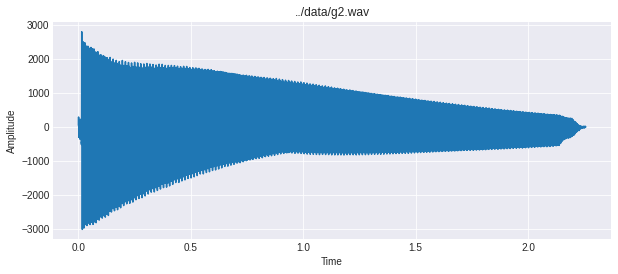

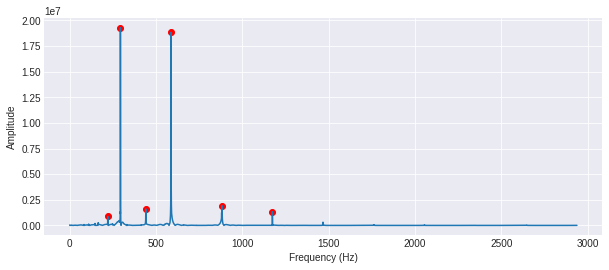

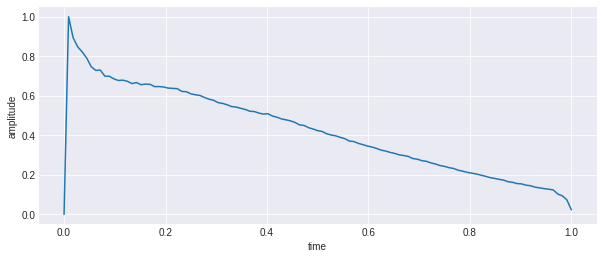

In [147]:
s = a.Sampler()
s.extract('../data/g2.wav')

In [148]:
[(a,b) for a,b in s.analyzed.rel_harmonics.values[0]]

[(0.75, 0.05), (1.0, 1.0), (1.5, 0.08), (2.0, 0.98), (3.0, 0.1), (4.0, 0.07)]

In [149]:
s.overtones,s.enveloppe = 0,0

In [150]:
s.frequency = 217

In [190]:
s.amplitude=2000

added overtones
WELL HELLP
44100 44100


array([  0.        ,   0.58024768,   2.31610302, ..., -17.45195195,
       -12.40267338,  -7.36191756])

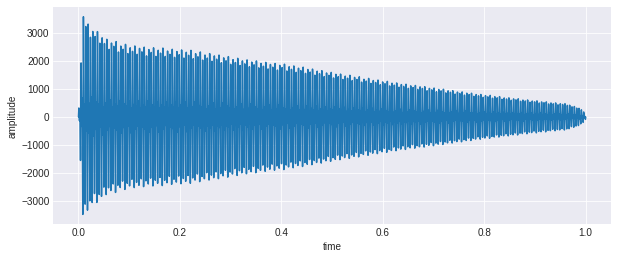

In [153]:
s.get_wave(1,freq=217)

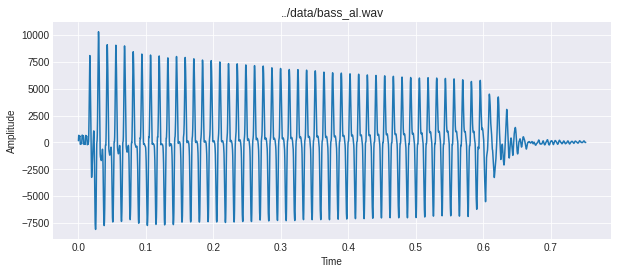

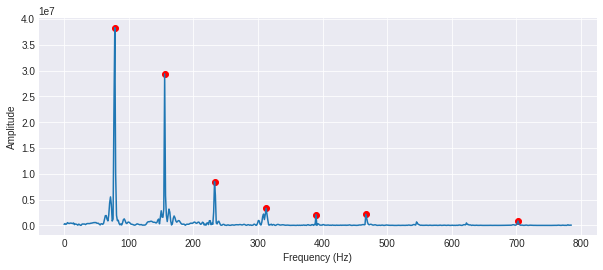

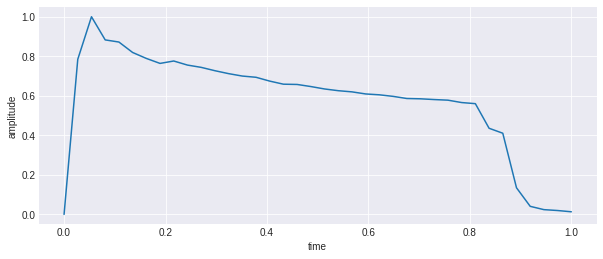

In [159]:
w.extract('../data/bass_al.wav')

In [ ]:
w.set_overtones(0)
w.set_enveloppe(False)

In [160]:
w.analyzed

,file,data,rel_harmonics,note,offpitch,enveloppe,frequency,duration
0,../data/g2.wav,"(44100, [52, 66, 80, 96, 111, 127, 142, 156, 1...","[(0.75, 0.05), (1.0, 1.0), (1.5, 0.08), (2.0, ...",D,0.9309874283592265 cents,"[[0.0, 0.008928571428571428, 0.017857142857142...",293.822731,2.256463
1,../data/bass_al.wav,"(44100, [157, 198, 238, 279, 317, 354, 390, 42...","[(1.0, 1.0), (1.98, 0.77), (2.97, 0.22), (3.98...",D#,15.7681971991964 cents,"[[0.0, 0.02702702702702703, 0.0540540540540540...",78.493423,0.751655


In [246]:
s.get_wave(1,freq=217)

In [189]:
import time

In [198]:
t = h.Tune('../data/weimar_jazz_database/RELEASE2.0_mid_unquant/MilesDavis_SoWhat_FINAL.mid')
t2 = h.Tune('../data/jazzbasslines/MilesDavis_SoWhat_Solo_bass.mid')

extraction took 0.010874748229980469 seconds
extraction took 0.008743762969970703 seconds


In [200]:
start = time.time()
w=s


df = t.df[(t.df.type == 'note_on')][['beat_time','data1']]

df['freq'] = np.array([h.Note(i).pitch.frequency for i in df.data1])

df['duration'] = np.array(list(np.diff(df.beat_time.values)) + [1])/4

a = [w.get_wave(d,freq=f,overtones=0,enveloppe=0,plot=False,wav=False) for d,f in zip(df.duration.to_numpy(),df.freq.to_numpy()/2)]
a = np.concatenate(a)
#a += np.concatenate([w.get_wave(d,freq=f,plot=False,wav=False) for d,f in zip(df.duration.to_numpy(),df.freq.to_numpy()*2/1.7)])



df = t2.df[(t2.df.type == 'note_on')][['beat_time','data1']]

df['freq'] = np.array([h.Note(i).pitch.frequency for i in df.data1])

df['duration'] = np.array(list(np.diff(df.beat_time.values)) + [1])/2.3336139528250124

b = [w.get_wave(d,freq=f,overtones=1,enveloppe=1,plot=False,wav=False) for d,f in zip(df.duration.to_numpy(),df.freq.to_numpy())]
b = np.concatenate(b)
#b += np.concatenate( [w.get_wave(d,freq=f,plot=False,wav=False) for d,f in zip(df.duration.to_numpy(),
#                                                                               df.freq.to_numpy()*2/1.7)] )

A = a + b[:-1] 
print(f"Took {start - time.time()}")
wavfile.write('milesguitar.wav', rate=44100, data=A.astype(np.int16))


added overtones
WELL HELLP
6030 6030
added overtones
WELL HELLP
14643 14643
added overtones
WELL HELLP
39334 39334
added overtones
WELL HELLP
13208 13208
added overtones
WELL HELLP
15217 15217
added overtones
WELL HELLP
4537 4537
added overtones
WELL HELLP
6661 6661
added overtones
WELL HELLP
5513 5513
added overtones
WELL HELLP
43928 43928
added overtones
WELL HELLP
5226 5226
added overtones
WELL HELLP
7178 7178
added overtones
WELL HELLP
7810 7810
added overtones
WELL HELLP
8154 8154
added overtones
WELL HELLP
7408 7408
added overtones
WELL HELLP
3848 3848
added overtones
WELL HELLP
9992 9992
added overtones
WELL HELLP
7293 7293
added overtones
WELL HELLP
8614 8614
added overtones
WELL HELLP
7236 7236
added overtones
WELL HELLP
21017 21017
added overtones
WELL HELLP
6604 6604
added overtones
WELL HELLP
7982 7982
added overtones
WELL HELLP
5800 5800
added overtones
WELL HELLP
16251 16251
added overtones
WELL HELLP
7982 7982
added overtones
WELL HELLP
4881 4881
added overtones
WELL HEL

WELL HELLP
23957 23957
added overtones
WELL HELLP
23012 23012
added overtones
WELL HELLP
20985 20985
added overtones
WELL HELLP
22875 22875
added overtones
WELL HELLP
21949 21949
added overtones
WELL HELLP
23111 23111
added overtones
WELL HELLP
21713 21713
added overtones
WELL HELLP
20394 20394
added overtones
WELL HELLP
20768 20768
added overtones
WELL HELLP
23642 23642
added overtones
WELL HELLP
21477 21477
added overtones
WELL HELLP
21792 21792
added overtones
WELL HELLP
15375 15375
added overtones
WELL HELLP
16890 16890
added overtones
WELL HELLP
14134 14134
added overtones
WELL HELLP
21339 21339
added overtones
WELL HELLP
19410 19410
added overtones
WELL HELLP
21792 21792
added overtones
WELL HELLP
24627 24627
added overtones
WELL HELLP
22953 22953
added overtones
WELL HELLP
21575 21575
added overtones
WELL HELLP
21418 21418
added overtones
WELL HELLP
22068 22068
added overtones
WELL HELLP
22205 22205
added overtones
WELL HELLP
22186 22186
added overtones
WELL HELLP
21260 21260
ad

In [204]:
import pygame
pygame.init()

pygame.mixer.music.load(A.astype(np.int16))
pygame.mixer.music.play()
pygame.event.wait()

error: not a file object

In [202]:
len(a)

2846678

In [183]:
2657219/2846678*2.5

2.3336139528250124